In [143]:
import sqlite3
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [204]:
# Connect to the database
db_path = '../../db/MasterDatabase.db'
connection = sqlite3.connect(db_path)

compound = 323
solvent_1 = 180
solvent_2 = 962
# compound = 1983
# solvent_1 = 679
# solvent_2 = 962
# compound = 2378
# solvent_1 = 702
# solvent_2 = 962

# Query to select the required columns
query = f"""
SELECT solvent_1_weight_fraction, solubility_g_g, temperature
FROM solubility
WHERE solvent_1 = {solvent_1} AND solvent_2 = {solvent_2} AND compound_id = {compound}
"""

# Execute the query and load the data into a pandas DataFrame
df = pd.read_sql_query(query, connection)
display(df)

# Close the database connection
connection.close()

,solvent_1_weight_fraction,solubility_g_g,temperature
0,0.2637,0.0048,268.15
1,0.4463,0.0225,268.15
2,0.5801,0.0468,268.15
3,0.6825,0.1061,268.15
4,0.7633,0.1538,268.15
...,...,...,...
82,0.8286,0.9654,303.15
83,0.8827,1.0020,303.15
84,0.9280,0.9848,303.15
85,0.9667,0.9602,303.15


In [205]:
# Filter the DataFrame for a specific temperature, e.g., 25°C
specific_temperature = 273.15
filtered_df = df[df['temperature'] == specific_temperature]

solvent_2_pure = filtered_df.loc[filtered_df['solvent_1_weight_fraction'] == 0, 'solubility_g_g'].values[0]
solvent_1_pure = filtered_df.loc[filtered_df['solvent_1_weight_fraction'] == 1.0000, 'solubility_g_g'].values[0]

print(f"Solvent 1 pure solubility: {solvent_1_pure} g/g")
print(f"Solvent 2 pure solubility: {solvent_2_pure} g/g")

Solvent 1 pure solubility: 0.3211 g/g
Solvent 2 pure solubility: 0.0001 g/g


## Cubic Function

In [146]:
# Define a cubic function
def cubic_function(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# Fit the cubic function to the data
popt, pcov = curve_fit(cubic_function, filtered_df['solvent_1_weight_fraction'], filtered_df['solubility_g_g'])

# Extract the fitted parameters
a, b, c, d = popt
print(f"Cubic fit parameters: a={a}, b={b}, c={c}, d={d}")

Cubic fit parameters: a=-4.749278119899563, b=7.536036637994303, c=-1.8618268497551638, d=0.01596086337666022


## JA Function

In [191]:
def jouyban_acree(f1, J0, J1, J2):
    import numpy as np
    
    # Calculate fraction of second solvent
    f2 = 1 - f1
    
    # Modified interaction term that reduces likelihood of bimodal behavior
    interaction_term = J0 * f1 * f2 + J1 * f1 * f2 * (2*f1 - 1) + J2 * f1 * f2 * (2*f1 - 1)**2
    
    # Calculate logarithm of solubility in the mixture
    log_Cm = f1 * np.log(solvent_1_pure) + f2 * np.log(solvent_2_pure) + \
             interaction_term / specific_temperature
    
    # Return the solubility in the mixture
    return np.exp(log_Cm)


popt, pcov = curve_fit(jouyban_acree, filtered_df['solvent_1_weight_fraction'], filtered_df['solubility_g_g'])
# Extract the fitted parameters
J0, J1, J2 = popt
print(f"Jouyban-Acree parameters: J0={J0}, J1={J1}, J2={J2}")

Jouyban-Acree parameters: J0=2181.669198496664, J1=-506.0188044954911, J2=660.5975296074016


## Combined Jouyban-Acree-van't Hoff

Paper 12

In [ ]:
def vant_hoff_model(T, alpha, beta):
    """
    van't Hoff model for solubility
    
    Parameters:
    T (array-like): Temperature in Kelvin
    alpha, beta (float): van't Hoff parameters
    
    Returns:
    array-like: Natural logarithm of solubility
    """
    return alpha + beta/T

params_solvent1, _ = curve_fit(vant_hoff_model, df[df['solvent_1_weight_fraction'] == 1.0]['temperature'], np.log(df[df['solvent_1_weight_fraction'] == 1.0]['solubility_g_g']))
params_solvent2, _ = curve_fit(vant_hoff_model, df[df['solvent_1_weight_fraction'] == 0.0]['temperature'], np.log(df[df['solvent_1_weight_fraction'] == 0.0]['solubility_g_g']))
alpha1, beta1 = params_solvent1
alpha2, beta2 = params_solvent2

def jouyban_acree_vant_hoff(independent_vars, J0, J1, J2):
    """    
    Parameters:
    independent_vars (tuple): Tuple containing (f1, T) where:
        f1 (array-like): Volume or mole fraction of solvent 1
        T (array-like): Absolute temperature in Kelvin
    alpha1, beta1 (float): van't Hoff constants for solvent 1
    alpha2, beta2 (float): van't Hoff constants for solvent 2
    J0, J1, J2 (float): Jouyban-Acree model parameters
    
    Returns:
    array-like: Natural logarithm of solubility in the mixed solvent
    """   
    # Unpack independent variables
    f1, T = independent_vars
    
    # Calculate fraction of second solvent
    f2 = 1 - f1
    
    # Calculate van't Hoff terms for each pure solvent
    vant_hoff_term1 = f1 * (alpha1 + beta1/T)
    vant_hoff_term2 = f2 * (alpha2 + beta2/T)
    
    # Calculate Jouyban-Acree interaction term
    interaction_term = f1 * f2 * (J0/T + J1*(f1-f2)/T + J2*(f1-f2)**2/T)
    
    # Calculate logarithm of solubility in the mixture
    ln_Xm = vant_hoff_term1 + vant_hoff_term2 + interaction_term
    
    return np.exp(ln_Xm)

popt, pcov = curve_fit(jouyban_acree_vant_hoff, (df['solvent_1_weight_fraction'],df['temperature']), df['solubility_g_g'])
# Extract the fitted parameters
J0, J1, J2 = popt
print(f"Combined Jouyban-Acree-van't Hoff parameters: alpha1={alpha1}, beta1={beta1}, alpha2={alpha2}, beta2={beta2}, J0={J0}, J1={J1}, J2={J2}")

Combined Jouyban-Acree-van't Hoff parameters: alpha1=18.619370015266153, beta1=-7673.829981080858, alpha2=9.34754729746264, beta2=-2862.7535683850197, J0=-661.736770195136, J1=7787.799491113306, J2=18644.44595184643


## Combined Jouyban-Acree with Apelblat

In [207]:
def jouyban_acree_apelblat(independent_vars, B1, B2, B3, B4, B5, B6, B7, B8, B9):
    """
    Implementation of Equation 9: Combined Jouyban-Acree-Apelblat Model
    
    Parameters:
    f1 (float): Volume or mole fraction of solvent 1
    T (float): Absolute temperature in Kelvin
    B1-B9 (float): Model parameters
    
    Returns:
    float: Natural logarithm of solubility in the mixed solvent
    """
    f1, T = independent_vars
    
    
    # Calculate logarithm of solubility using the combined model
    ln_Xm = (B1 + B2/T + B3*np.log(T) + 
             B4*f1 + B5*f1/T + 
             B6*f1**2/T + B7*f1**3/T + B8*f1**4/T + 
             B9*f1*np.log(T))
    
    return np.exp(ln_Xm)

popt, pcov = curve_fit(jouyban_acree_apelblat, (df['solvent_1_weight_fraction'],df['temperature']), df['solubility_g_g'])
# Extract the fitted parameters
B1, B2, B3, B4, B5, B6, B7, B8, B9 = popt
print(f"Combined Jouyban-Acree-Apelblat parameters: B1={B1}, B2={B2}, B3={B3}, B4={B4}, B5={B5}, B6={B6}, B7={B7}, B8={B8}, B9={B9}")

Combined Jouyban-Acree-Apelblat parameters: B1=-718.1698101469667, B2=19173.821903104606, B3=112.02744992463302, B4=700.2028153470385, B5=-6231.977300614236, B6=-32880.52544585068, B7=27022.1559221925, B8=-8758.924442390773, B9=-107.9321084343835


# Plots

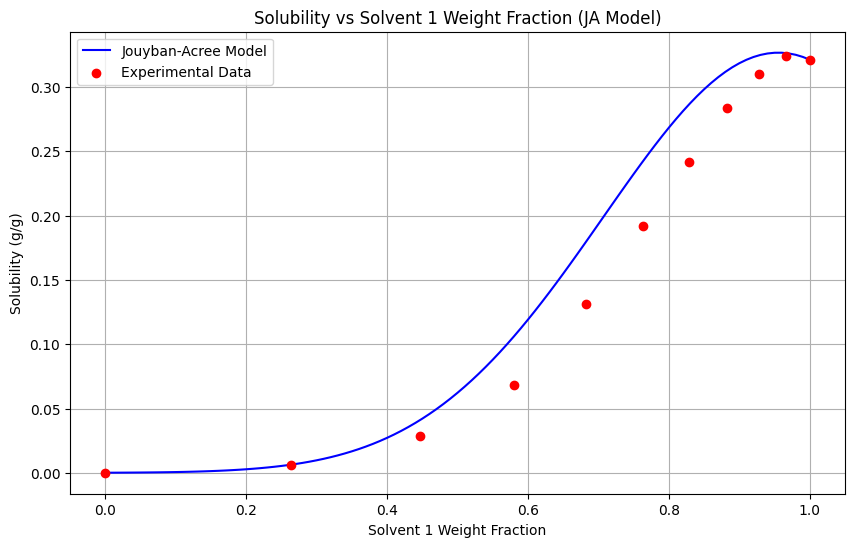

In [198]:

x_values = np.linspace(0, 1, 101)

# cubic_fit_values = cubic_function(x_values, a, b, c, d)
jouyban_acree_fit_values = jouyban_acree(x_values, J0, J1, J2)

# Plot the JA model
plt.figure(figsize=(10, 6))
# Plot the cubic fit
# plt.plot(x_values, cubic_fit_values, label='Cubic Fit', color='green')
plt.plot(x_values, jouyban_acree_fit_values, label='Jouyban-Acree Model', color='blue')

# Add the experimental data points to the plot
plt.scatter(filtered_df['solvent_1_weight_fraction'], filtered_df['solubility_g_g'], color='red', label='Experimental Data', zorder=5)
plt.xlabel('Solvent 1 Weight Fraction')
plt.ylabel('Solubility (g/g)')
plt.title('Solubility vs Solvent 1 Weight Fraction (JA Model)')
plt.legend()
plt.grid(True)
plt.show()


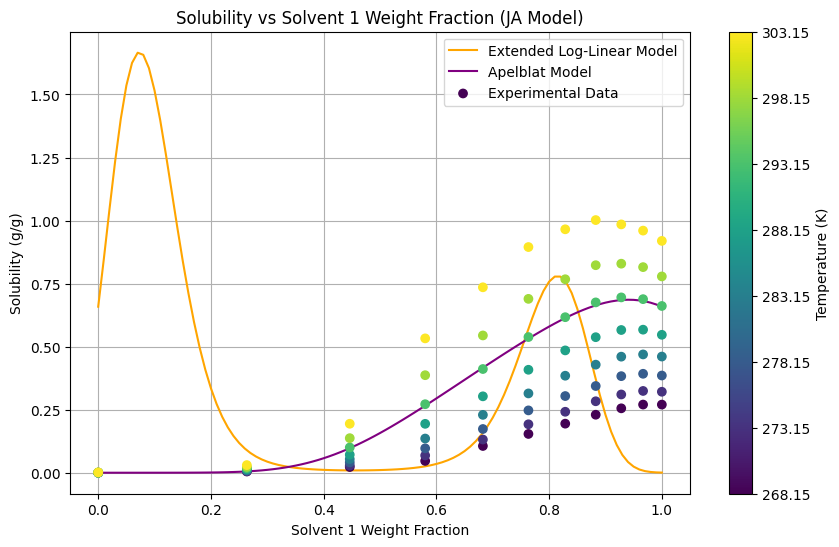

In [210]:
x_values = np.linspace(0, 1, 101)

log_linear_values = jouyban_acree_vant_hoff((x_values, 293.15), J0, J1, J2)
apelbat_values = jouyban_acree_apelblat((x_values, 293.15), B1, B2, B3, B4, B5, B6, B7, B8, B9)

plt.figure(figsize=(10, 6))
plt.plot(x_values, log_linear_values, label='Extended Log-Linear Model', color='orange')
plt.plot(x_values, apelbat_values, label='Apelblat Model', color='purple')
# Add the experimental data points to the plot
scatter = plt.scatter(df['solvent_1_weight_fraction'], df['solubility_g_g'], c=df['temperature'], cmap='viridis', label='Experimental Data', zorder=5)
plt.xlabel('Solvent 1 Weight Fraction')
plt.ylabel('Solubility (g/g)')
plt.title('Solubility vs Solvent 1 Weight Fraction (JA Model)')
plt.legend()
plt.colorbar(scatter, label='Temperature (K)', ticks=df['temperature'].unique())  # Add a colorbar with exact temperature values
plt.grid(True)
plt.show()
